In [1]:
import scanpy as sc
import pandas as pd
import anndata as ad
import glob
import numpy as np
from scipy.sparse import csr_matrix

In [2]:
sc.logging.print_header()

scanpy==1.8.1 anndata==0.7.6 umap==0.5.1 numpy==1.20.3 scipy==1.6.2 pandas==1.3.0 scikit-learn==0.24.2 statsmodels==0.12.2 python-igraph==0.9.6 pynndescent==0.5.4


In [3]:
#load data from cellranger aggr (no normalization)
#adata= sc.read_10x_mtx("/project2/gilad/katie/ebQTL/highpass_combinedFiles/HighpassAgg_All102Libs_noNorm/outs/count/filtered_feature_bc_matrix/")
adata= sc.read_h5ad("/project2/gilad/katie/ebQTL/highpass_combinedFiles/102andPilot_NoMeta_noNorm.h5ad")

In [4]:
adata

AnnData object with n_obs × n_vars = 1825288 × 36601
    var: 'gene_ids', 'feature_types'

In [5]:
adata.obs.head()
#the number appended to the barcode corresponds to the row number of the sample/file in the csv input to cellranger aggr

""
AAACCCAAGAGAGCCT-1
AAACCCAAGATCCCAT-1
AAACCCAAGCTCCCTT-1
AAACCCAAGCTCGACC-1
AAACCCAAGGGTACAC-1


In [6]:
#load cellranger aggr input csv to match libprep metadata to each barcode
aggr_input = pd.read_csv('/project2/gilad/katie/ebQTL/CellrangerAggInput_includingPilot.csv')

In [7]:
aggr_input.tail()
#remember that python rownames start at 0!

,sample_id,molecule_h5,Collection.Date,Lane,Sample.ID,cDNA.amp.cycles,cDNA.total.yield,library.prep.batch,Sequencing.batch,col.group
113,0829_4,/project2/gilad/kenneth/ebQTL/highpass/batchP/...,8/29/2019,4,082919_4,NaN,NaN,P2,P2,82919
114,0911_1,/project2/gilad/kenneth/ebQTL/highpass/batchP/...,9/11/2019,1,091119_1,NaN,NaN,P3,P3,91119
115,0911_2,/project2/gilad/kenneth/ebQTL/highpass/batchP/...,9/11/2019,2,091119_2,NaN,NaN,P3,P3,91119
116,0911_3,/project2/gilad/kenneth/ebQTL/highpass/batchP/...,9/11/2019,3,091119_3,NaN,NaN,P3,P3,91119
117,0911_4,/project2/gilad/kenneth/ebQTL/highpass/batchP/...,9/11/2019,4,091119_4,NaN,NaN,P3,P3,91119


In [8]:
#need to do the equivalent of left_join by rownames. take last character of barcode (x), x-1=index of matching row in aggr_input
#add a column to adata.obs that is the appended number -1 (to correspond to indices in aggr_input)
keys=list(adata.obs.index)
keys = [ s[s.find("-")+1:] for s in keys]
keys = pd.to_numeric(keys)-1
adata.obs['key']= keys

#I'll also need the barcode without the appended number to assign vireo results, so I'll add that column now
#will delete this column and key column before finalizing the adata file
bar = list(adata.obs.index)
bar = [s[:s.find("-")] for s in bar]
adata.obs['barcode_notunique'] = bar

#left join adata.obs and aggr_input by "key"
meta = adata.obs.join(aggr_input, on='key')

#meta will replace adata.obs later after all info has been added

In [9]:
meta.tail()

,key,barcode_notunique,sample_id,molecule_h5,Collection.Date,Lane,Sample.ID,cDNA.amp.cycles,cDNA.total.yield,library.prep.batch,Sequencing.batch,col.group
TTTGTTGGTGGACCAA-118,117,TTTGTTGGTGGACCAA,0911_4,/project2/gilad/kenneth/ebQTL/highpass/batchP/...,9/11/2019,4,091119_4,NaN,NaN,P3,P3,91119
TTTGTTGGTTCTCTCG-118,117,TTTGTTGGTTCTCTCG,0911_4,/project2/gilad/kenneth/ebQTL/highpass/batchP/...,9/11/2019,4,091119_4,NaN,NaN,P3,P3,91119
TTTGTTGGTTTGGAGG-118,117,TTTGTTGGTTTGGAGG,0911_4,/project2/gilad/kenneth/ebQTL/highpass/batchP/...,9/11/2019,4,091119_4,NaN,NaN,P3,P3,91119
TTTGTTGTCCAGCACG-118,117,TTTGTTGTCCAGCACG,0911_4,/project2/gilad/kenneth/ebQTL/highpass/batchP/...,9/11/2019,4,091119_4,NaN,NaN,P3,P3,91119
TTTGTTGTCCTCTCGA-118,117,TTTGTTGTCCTCTCGA,0911_4,/project2/gilad/kenneth/ebQTL/highpass/batchP/...,9/11/2019,4,091119_4,NaN,NaN,P3,P3,91119


In [10]:
#make list of sequencing batch, but replace P1:3 with just P
bt= aggr_input['Sequencing.batch']
bt[bt == "P1"] = "P"
bt[bt == "P2"] = "P"
bt[bt == "P3"] = "P"

/project2/gilad/katie/miniconda3/envs/Scvi2andKmeans/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/project2/gilad/katie/miniconda3/envs/Scvi2andKmeans/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/project2/gilad/katie/miniconda3/envs/Scvi2andKmeans/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See th

In [11]:
aggr_input['Sequencing.batch'] = bt

In [12]:
aggr_input['Sequencing.batch']

0      1
1      1
2      1
3      1
4      1
      ..
113    P
114    P
115    P
116    P
117    P
Name: Sequencing.batch, Length: 118, dtype: object

In [13]:
aggr_input["Sequencing.batch"][aggr_input["sample_id"] == str("0911_1")].values[0]

'P'

In [14]:
#load vireo outs for new (not pilot) data

#with a for loop for each sample_id, load each donor_ids.tsv file, fix the cell barcode to match appropriate adata.obs index
#(pull rowname from row with matching sample_id), then append to a dataframe that will hold all vireo results
vireo_all = pd.DataFrame()
nop= aggr_input[aggr_input['Sequencing.batch'] != "P"]
id = list(nop['sample_id'].unique())
for i in id:
    coldate = i[0:4]
    lane = i[-1:]
    bat = aggr_input["Sequencing.batch"][aggr_input["sample_id"] == str(i)].values[0]
    path = "/project2/gilad/kenneth/ebQTL/highpass/batch" + str(bat) +"/" + str(coldate) + "/"
    vir =  glob.glob(path+ "*-"+ lane +"_human/vireo/donor_ids.tsv")
    vdf = pd.read_csv(vir[0], sep="\t")
    vbar = vdf['cell']
    vbar = [s[:s.find("-")] for s in vbar]
    vkey = meta['key'][list(meta['sample_id']).index(i)]
    vkey = pd.to_numeric(vkey)+1
    newbar = [b + "-" + str(vkey) for b in vbar]
    vdf['cell'] = newbar
    vireo_all = vireo_all.append(vdf)

    


In [15]:
#make df for pilot samples with PilotBatch# column
ponly= aggr_input[aggr_input['Sequencing.batch'] == "P"]
plib = ponly['library.prep.batch']
plib[plib == "P1"]= "Batchl"
plib[plib == "P2"]= "Batch2"
plib[plib == "P3"]= "Batch3"
ponly['PilotBatchNum'] = plib
ponly

/project2/gilad/katie/miniconda3/envs/Scvi2andKmeans/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/project2/gilad/katie/miniconda3/envs/Scvi2andKmeans/lib/python3.7/site-packages/pandas/core/generic.py:8861: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/project2/gilad/katie/miniconda3/envs/Scvi2andKmeans/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

,sample_id,molecule_h5,Collection.Date,Lane,Sample.ID,cDNA.amp.cycles,cDNA.total.yield,library.prep.batch,Sequencing.batch,col.group,PilotBatchNum
102,0816_1,/project2/gilad/kenneth/ebQTL/highpass/batchP/...,8/16/2019,1,081619_1,NaN,NaN,Batchl,P,81619,Batchl
103,0816_3,/project2/gilad/kenneth/ebQTL/highpass/batchP/...,8/16/2019,3,081619_3,NaN,NaN,Batchl,P,81619,Batchl
104,0816_4,/project2/gilad/kenneth/ebQTL/highpass/batchP/...,8/16/2019,4,081619_4,NaN,NaN,Batchl,P,81619,Batchl
105,0816_5,/project2/gilad/kenneth/ebQTL/highpass/batchP/...,8/16/2019,5,081619_5,NaN,NaN,Batchl,P,81619,Batchl
106,0816_6,/project2/gilad/kenneth/ebQTL/highpass/batchP/...,8/16/2019,6,081619_6,NaN,NaN,Batchl,P,81619,Batchl
107,0816_7,/project2/gilad/kenneth/ebQTL/highpass/batchP/...,8/16/2019,7,081619_7,NaN,NaN,Batchl,P,81619,Batchl
108,0816_8,/project2/gilad/kenneth/ebQTL/highpass/batchP/...,8/16/2019,8,081619_8,NaN,NaN,Batchl,P,81619,Batchl
109,0816_9,/project2/gilad/kenneth/ebQTL/highpass/batchP/...,8/16/2019,9,081619_9,NaN,NaN,Batchl,P,81619,Batchl
110,0829_1,/project2/gilad/kenneth/ebQTL/highpass/batchP/...,8/29/2019,1,082919_1,NaN,NaN,Batch2,P,82919,Batch2
111,0829_2,/project2/gilad/kenneth/ebQTL/highpass/batchP/...,8/29/2019,2,082919_2,NaN,NaN,Batch2,P,82919,Batch2


In [16]:

#load vireo outs for pilot (directory nomenclature is slightly different), append to vireo_all
pid = list(ponly['sample_id'].unique())
for i in pid:
    coldate = i[0:4]
    lane = i[-1:]
    bat = "P"
    pbat = ponly['PilotBatchNum'][ponly["sample_id"] == str(i)].values[0]
    path = "/project2/gilad/kenneth/ebQTL/highpass/batch" + str(bat) +"/" + str(coldate) + "/"
    vir =  glob.glob(path+ "*_Lane"+ lane +"_human/vireo/donor_ids.tsv")
    vdf = pd.read_csv(vir[0], sep="\t")
    vbar = vdf['cell']
    vbar = [s[:s.find("-")] for s in vbar]
    vkey = meta['key'][list(meta['sample_id']).index(i)]
    vkey = pd.to_numeric(vkey)+1
    newbar = [b + "-" + str(vkey) for b in vbar]
    vdf['cell'] = newbar
    vireo_all = vireo_all.append(vdf)

In [17]:
vir[0]

'/project2/gilad/kenneth/ebQTL/highpass/batchP/0911/Batch3_Lane4_human/vireo/donor_ids.tsv'

In [18]:
vireo_all = vireo_all.set_index('cell')

In [19]:
vireo_all.head(20)

,donor_id,prob_max,prob_doublet,n_vars,best_singlet,best_doublet,doublet_logLikRatio
cell,,,,,,,
AAACCCAAGAGAGCCT-1,NA19190,1.000000e+00,1.720000e-34,621,NA19190,"NA19190,NA18870",-75.646
AAACCCAAGATCCCAT-1,NA18913,9.980000e-01,1.080000e-03,114,NA18913,"NA18913,NA19101",-4.731
AAACCCAAGCTCCCTT-1,NA18870,1.000000e+00,3.820000e-40,776,NA18870,"NA19190,NA19101",-88.668
AAACCCAAGCTCGACC-1,doublet,3.270000e-141,1.000000e+00,1502,NA19101,"NA19190,NA18870",325.577
AAACCCAAGGGTACAC-1,NA18870,1.000000e+00,2.130000e-26,387,NA18870,"NA18913,NA18870",-57.015
AAACCCAAGTACTCGT-1,NA18870,1.000000e+00,7.680000e-45,728,NA18870,"NA19190,NA19101",-99.481
AAACCCACACGAGAAC-1,doublet,7.660000e-09,1.000000e+00,153,NA18913,"NA18913,NA18870",20.783
AAACCCACACGGCGTT-1,NA18870,1.000000e+00,3.620000e-262,2145,NA18870,"NA19190,NA18913",-599.894
AAACCCACACTTACAG-1,doublet,2.260000e-08,9.950000e-01,145,NA18913,"NA18913,NA18870",19.696


In [20]:
#add vireo outs to meta by index
meta = meta.join(vireo_all)

In [21]:
meta.shape

(1825288, 19)

In [22]:
meta.head()

,key,barcode_notunique,sample_id,molecule_h5,Collection.Date,Lane,Sample.ID,cDNA.amp.cycles,cDNA.total.yield,library.prep.batch,Sequencing.batch,col.group,donor_id,prob_max,prob_doublet,n_vars,best_singlet,best_doublet,doublet_logLikRatio
AAACCCAAGAGAGCCT-1,0,AAACCCAAGAGAGCCT,1001_1,/project2/gilad/kenneth/ebQTL/highpass/batch1/...,10/1/2020,1,100120_1,11.0,393.02,1,1,100120,NA19190,1.000000e+00,1.720000e-34,621,NA19190,"NA19190,NA18870",-75.646
AAACCCAAGATCCCAT-1,0,AAACCCAAGATCCCAT,1001_1,/project2/gilad/kenneth/ebQTL/highpass/batch1/...,10/1/2020,1,100120_1,11.0,393.02,1,1,100120,NA18913,9.980000e-01,1.080000e-03,114,NA18913,"NA18913,NA19101",-4.731
AAACCCAAGCTCCCTT-1,0,AAACCCAAGCTCCCTT,1001_1,/project2/gilad/kenneth/ebQTL/highpass/batch1/...,10/1/2020,1,100120_1,11.0,393.02,1,1,100120,NA18870,1.000000e+00,3.820000e-40,776,NA18870,"NA19190,NA19101",-88.668
AAACCCAAGCTCGACC-1,0,AAACCCAAGCTCGACC,1001_1,/project2/gilad/kenneth/ebQTL/highpass/batch1/...,10/1/2020,1,100120_1,11.0,393.02,1,1,100120,doublet,3.270000e-141,1.000000e+00,1502,NA19101,"NA19190,NA18870",325.577
AAACCCAAGGGTACAC-1,0,AAACCCAAGGGTACAC,1001_1,/project2/gilad/kenneth/ebQTL/highpass/batch1/...,10/1/2020,1,100120_1,11.0,393.02,1,1,100120,NA18870,1.000000e+00,2.130000e-26,387,NA18870,"NA18913,NA18870",-57.015


In [23]:
#load formation and collection metadata
formcol = pd.read_csv('/project2/gilad/katie/ebQTL/CombinedFormationAndCollectionMetadata_102andPilot_SWAPSANDCONTAMINATIONADDED_012522.csv')
formcol.head()

,Line.StockLabel,contaminated,swapped,Line.True,Feeder.passage,Feeder.Free.passage,sex,Formation.replicate,collection.replicate,formation.date,...,X..Viable..based.on.average.of.two.counts.,days.maintained.in.LD.prior.to.formation,who.dissociated.the.lines.for.formation,cell.counter.correction,comments,collection.date,collection.group.label,EB.appearance.notes,dissociated.by.,approx..time.in.accumax..in.minutes.
0,18913,no,no,18913,23.0,20.0,M,1.0,1.0,9/10/2020,...,77.5,4.0,Katie,TC20,NaN,10/1/2020,100120,"manys EBs, variable size, no dark spots",katie,15.0
1,19190,no,no,19190,13.0,18.0,F,1.0,1.0,9/10/2020,...,74.0,3.0,Katie,TC20,NaN,10/1/2020,100120,"few large EBs, some colored spots",katie,25.0
2,18870,no,no,18870,18.0,22.0,F,1.0,1.0,9/10/2020,...,89.0,3.0,Katie,TC20,NaN,10/1/2020,100120,"variable size, some translucent areas, some da...",kenneth,35.0
3,19101,no,no,19101,12.0,19.0,M,1.0,1.0,9/10/2020,...,89.5,3.0,Katie,TC20,NaN,10/1/2020,100120,"large, dense EBs with some debris in the wells",kenneth,35.0
4,19190,no,no,19190,13.0,19.0,F,2.0,2.0,9/14/2020,...,76.0,3.0,katie,TC20,NaN,10/5/2020,100520,NaN,kenneth,40.0


In [24]:
formcol.shape

(116, 22)

In [25]:
#merge by best_singlet/Line.True and first 4 characters of meta$col.group and formcol$collection.group.label
#there are extra cols in the formcol df due to samples that didn't work out, so left join that to meta

#make new column in meta that is the best singlet without the "NA" in front
bests = meta['best_singlet']
bests = [s[s.find("A")+1:] for s in bests]
meta['Line.True'] = bests #note: for lines that are vireo says are doublets are unassigned, the "Line.True" column will match "best_singlet"
#meta['Line.True'] = meta['Line.True'].astype(int)
formcol['Line.True'] = formcol['Line.True'].astype(str)
meta['Line.True'] = meta['Line.True'].astype(str)
meta['col.group'] = meta['col.group'].astype(int)

#left join by "Line.True" and "col.group"
meta = pd.merge(meta, formcol,  how='left', left_on=['Line.True', "col.group"], right_on=['Line.True','collection.group.label'])

#put index back to barcodes
meta.set_index(vireo_all.index, inplace=True)

In [26]:
meta.head()

,key,barcode_notunique,sample_id,molecule_h5,Collection.Date,Lane,Sample.ID,cDNA.amp.cycles,cDNA.total.yield,library.prep.batch,...,X..Viable..based.on.average.of.two.counts.,days.maintained.in.LD.prior.to.formation,who.dissociated.the.lines.for.formation,cell.counter.correction,comments,collection.date,collection.group.label,EB.appearance.notes,dissociated.by.,approx..time.in.accumax..in.minutes.
cell,,,,,,,,,,,,,,,,,,,,,
AAACCCAAGAGAGCCT-1,0,AAACCCAAGAGAGCCT,1001_1,/project2/gilad/kenneth/ebQTL/highpass/batch1/...,10/1/2020,1,100120_1,11.0,393.02,1,...,74.0,3.0,Katie,TC20,NaN,10/1/2020,100120.0,"few large EBs, some colored spots",katie,25.0
AAACCCAAGATCCCAT-1,0,AAACCCAAGATCCCAT,1001_1,/project2/gilad/kenneth/ebQTL/highpass/batch1/...,10/1/2020,1,100120_1,11.0,393.02,1,...,77.5,4.0,Katie,TC20,NaN,10/1/2020,100120.0,"manys EBs, variable size, no dark spots",katie,15.0
AAACCCAAGCTCCCTT-1,0,AAACCCAAGCTCCCTT,1001_1,/project2/gilad/kenneth/ebQTL/highpass/batch1/...,10/1/2020,1,100120_1,11.0,393.02,1,...,89.0,3.0,Katie,TC20,NaN,10/1/2020,100120.0,"variable size, some translucent areas, some da...",kenneth,35.0
AAACCCAAGCTCGACC-1,0,AAACCCAAGCTCGACC,1001_1,/project2/gilad/kenneth/ebQTL/highpass/batch1/...,10/1/2020,1,100120_1,11.0,393.02,1,...,89.5,3.0,Katie,TC20,NaN,10/1/2020,100120.0,"large, dense EBs with some debris in the wells",kenneth,35.0
AAACCCAAGGGTACAC-1,0,AAACCCAAGGGTACAC,1001_1,/project2/gilad/kenneth/ebQTL/highpass/batch1/...,10/1/2020,1,100120_1,11.0,393.02,1,...,89.0,3.0,Katie,TC20,NaN,10/1/2020,100120.0,"variable size, some translucent areas, some da...",kenneth,35.0


In [27]:
meta.shape

(1825288, 41)

In [28]:
meta.columns

Index(['key', 'barcode_notunique', 'sample_id', 'molecule_h5',
       'Collection.Date', 'Lane', 'Sample.ID', 'cDNA.amp.cycles',
       'cDNA.total.yield', 'library.prep.batch', 'Sequencing.batch',
       'col.group', 'donor_id', 'prob_max', 'prob_doublet', 'n_vars',
       'best_singlet', 'best_doublet', 'doublet_logLikRatio', 'Line.True',
       'Line.StockLabel', 'contaminated', 'swapped', 'Feeder.passage',
       'Feeder.Free.passage', 'sex', 'Formation.replicate',
       'collection.replicate', 'formation.date', 'visual.confluence',
       'total.cells.per.lane..correct.',
       'X..Viable..based.on.average.of.two.counts.',
       'days.maintained.in.LD.prior.to.formation',
       'who.dissociated.the.lines.for.formation', 'cell.counter.correction',
       'comments', 'collection.date', 'collection.group.label',
       'EB.appearance.notes', 'dissociated.by.',
       'approx..time.in.accumax..in.minutes.'],
      dtype='object')

In [29]:
#remove unwanted columns: key, barcode_notunique, molecule_h5
meta = meta.drop(['key', 'barcode_notunique', 'molecule_h5'], axis=1)

In [30]:
#set meta as adata.obs, make sure indices are the barcodes
adata.obs = meta
adata

AnnData object with n_obs × n_vars = 1825288 × 36601
    obs: 'sample_id', 'Collection.Date', 'Lane', 'Sample.ID', 'cDNA.amp.cycles', 'cDNA.total.yield', 'library.prep.batch', 'Sequencing.batch', 'col.group', 'donor_id', 'prob_max', 'prob_doublet', 'n_vars', 'best_singlet', 'best_doublet', 'doublet_logLikRatio', 'Line.True', 'Line.StockLabel', 'contaminated', 'swapped', 'Feeder.passage', 'Feeder.Free.passage', 'sex', 'Formation.replicate', 'collection.replicate', 'formation.date', 'visual.confluence', 'total.cells.per.lane..correct.', 'X..Viable..based.on.average.of.two.counts.', 'days.maintained.in.LD.prior.to.formation', 'who.dissociated.the.lines.for.formation', 'cell.counter.correction', 'comments', 'collection.date', 'collection.group.label', 'EB.appearance.notes', 'dissociated.by.', 'approx..time.in.accumax..in.minutes.'
    var: 'gene_ids', 'feature_types'

In [31]:
#save adata (completely unfiltered, still contains non-singlets and low quality cells)
adata.X = csr_matrix(adata.X)
adata.write(filename= "/project2/gilad/katie/ebQTL/highpass_combinedFiles/102andPilot_MetaAdded_noNorm.h5ad")

/project2/gilad/katie/miniconda3/envs/Scvi2andKmeans/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'sample_id' as categorical
/project2/gilad/katie/miniconda3/envs/Scvi2andKmeans/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'Collection.Date' as categorical
/project2/gilad/katie/miniconda3/envs/Scvi2andKmeans/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in 

In [32]:
adata.shape

#(cells, genes)

(1825288, 36601)

In [33]:
#how many doublets/unassigned/cells per individual?
did = adata.obs['donor_id'].value_counts()
did

doublet       461787
unassigned    268344
NA18858        63057
NA18499        48257
NA18508        46140
NA18862        35568
NA19193        32291
NA18502        30568
NA18489        28150
NA19206        26233
NA19160        25246
NA19204        25123
NA18856        25087
NA19116        24477
NA19140        24231
NA18486        23429
NA19130        22549
NA18505        22148
NA18855        21752
NA18511        21398
NA19102        21051
NA19144        20787
NA19143        20688
NA18519        20654
NA18912        20640
NA18507        20441
NA19098        20335
NA18517        20277
NA19093        20253
NA19127        20134
NA18913        20011
NA19225        19434
NA18520        19120
NA18522        18977
NA19159        18633
NA19207        17809
NA18907        17674
NA19210        17349
NA19153        16550
NA18516        15679
NA18510        14663
NA18870        13423
NA19152        13249
NA19114        12813
NA19099        12795
NA18501        12326
NA19190        11468
NA19209      

In [34]:
#n individuals
len(did)-2

56

In [35]:
#(%doublet, %unassigned) in whole data set (will vary by col.group)
print(did['doublet'].astype(int)/sum(did.astype(int)),did['unassigned'].astype(int)/sum(did.astype(int)) )
#note, this doesnt represent the true doublet rate. cellranger doesnt do a great job calling cells here (because we 
#sequenced so deeply, even empty droplets don't look empty to cellranger (they look significantly different from "background"))
#all unassigned cells are likely empty droplets and most "doublets" are also empty droplets

0.2529940480625523 0.14701460810567976


In [36]:
#cells per donor id per collection replicate
tmp = pd.crosstab(adata.obs['donor_id'],adata.obs['col.group'])
tmp

col.group,81619,82919,91119,100120,100520,100820,101220,101520,101920,102220,102620,102920,110220,110520,110920,111220,111620,111920,120920,121420
donor_id,,,,,,,,,,,,,,,,,,,,
H28834,6952,738,144,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
NA18486,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12785,10644,0,0,0
NA18489,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12526,15624,0,0,0
NA18498,0,0,0,0,0,0,0,0,0,1079,954,0,0,0,0,0,0,0,0,0
NA18499,0,0,0,0,0,0,0,0,10279,24361,13617,0,0,0,0,0,0,0,0,0
NA18501,0,0,0,0,5295,0,0,0,0,0,0,0,0,0,0,0,0,7031,0,0
NA18502,0,0,0,0,0,13449,0,0,0,0,0,0,0,0,0,0,8690,8429,0,0
NA18505,0,0,0,0,5980,16168,0,0,0,0,0,0,0,0,0,0,0,0,0,0
NA18507,0,0,0,0,0,0,0,0,0,9584,10857,0,0,0,0,0,0,0,0,0


In [37]:
# percent of cells per donor id per collection replicate
tmp = pd.crosstab(adata.obs['donor_id'],adata.obs['col.group'], normalize= 'columns')
tmp

col.group,81619,82919,91119,100120,100520,100820,101220,101520,101920,102220,102620,102920,110220,110520,110920,111220,111620,111920,120920,121420
donor_id,,,,,,,,,,,,,,,,,,,,
H28834,0.098387,0.020355,0.002927,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
NA18486,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.118313,0.088039,0.000000,0.000000,0.000000
NA18489,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.115916,0.129230,0.000000,0.000000,0.000000
NA18498,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008198,0.008398,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
NA18499,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.096042,0.185094,0.119876,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
NA18501,0.000000,0.000000,0.000000,0.000000,0.048407,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.141608,0.000000,0.000000
NA18502,0.000000,0.000000,0.000000,0.000000,0.000000,0.145890,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.071877,0.169765,0.000000,0.000000
NA18505,0.000000,0.000000,0.000000,0.000000,0.054669,0.175385,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
NA18507,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.072819,0.095579,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [38]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

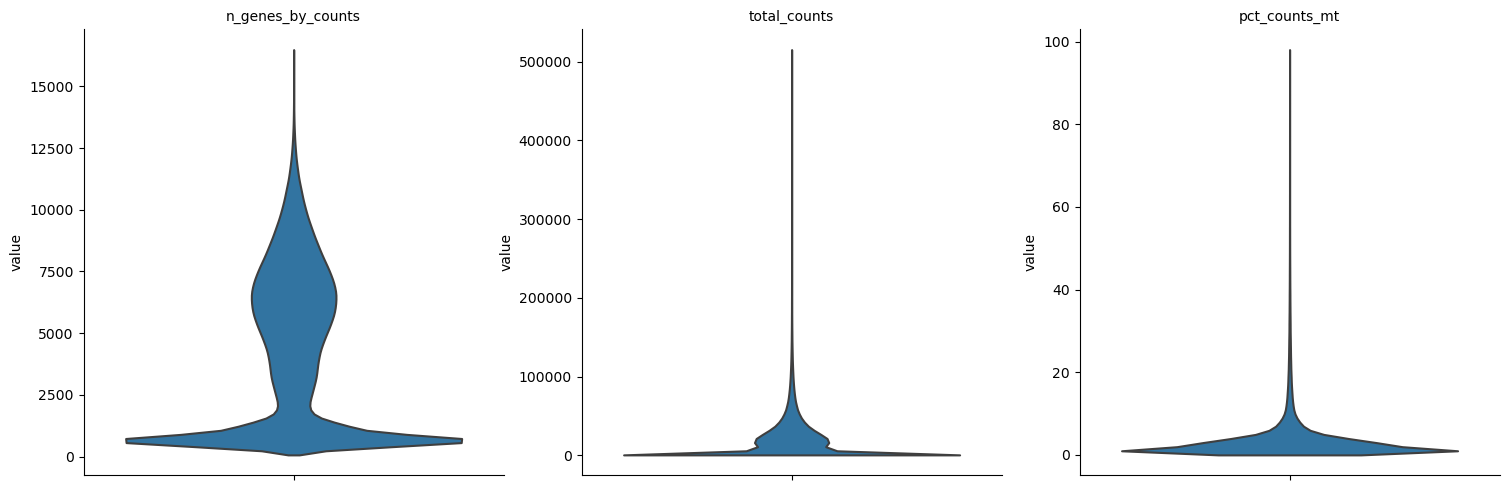

In [39]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True, size=0)

In [40]:
vireo_all['donor_id'].value_counts()

doublet       461787
unassigned    268344
NA18858        63057
NA18499        48257
NA18508        46140
NA18862        35568
NA19193        32291
NA18502        30568
NA18489        28150
NA19206        26233
NA19160        25246
NA19204        25123
NA18856        25087
NA19116        24477
NA19140        24231
NA18486        23429
NA19130        22549
NA18505        22148
NA18855        21752
NA18511        21398
NA19102        21051
NA19144        20787
NA19143        20688
NA18519        20654
NA18912        20640
NA18507        20441
NA19098        20335
NA18517        20277
NA19093        20253
NA19127        20134
NA18913        20011
NA19225        19434
NA18520        19120
NA18522        18977
NA19159        18633
NA19207        17809
NA18907        17674
NA19210        17349
NA19153        16550
NA18516        15679
NA18510        14663
NA18870        13423
NA19152        13249
NA19114        12813
NA19099        12795
NA18501        12326
NA19190        11468
NA19209      

In [41]:
np.show_config()

blas_mkl_info:
    libraries = ['mkl_rt', 'pthread']
    library_dirs = ['/project2/gilad/katie/miniconda3/envs/Scvi2andKmeans/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['/project2/gilad/katie/miniconda3/envs/Scvi2andKmeans/include']
blas_opt_info:
    libraries = ['mkl_rt', 'pthread']
    library_dirs = ['/project2/gilad/katie/miniconda3/envs/Scvi2andKmeans/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['/project2/gilad/katie/miniconda3/envs/Scvi2andKmeans/include']
lapack_mkl_info:
    libraries = ['mkl_rt', 'pthread']
    library_dirs = ['/project2/gilad/katie/miniconda3/envs/Scvi2andKmeans/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['/project2/gilad/katie/miniconda3/envs/Scvi2andKmeans/include']
lapack_opt_info:
    libraries = ['mkl_rt', 'pthread']
    library_dirs = ['/project2/gilad/katie/miniconda3/envs/Scvi2andKmeans/lib']
    define_mac